# Synthetic classification tasks

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import tqdm

from pytorchtools import EarlyStopping

import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
tu.set_seed()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

Random seed set as 42


device(type='cuda')

### Load M. buryatense expression data with 300bp upstream regions

In [3]:
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf = pd.read_csv(data_filename,sep='\t')
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,0.047594,0.823884,-0.215152,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,0.175844,1.069860,-0.135315,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,0.087538,0.940938,-0.153989,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,0.032773,0.520115,-0.260747,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,0.064979,-0.141051,0.073257,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,0.008150,-0.382673,1.440100,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,-0.005709,-0.374488,1.421917,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,0.015365,-0.322437,1.406791,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,-0.183282,0.157790,-0.270536,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502


## Task 1: Synthetic 3-mer motif classification in 6bp seqs
### Add classification label column
Take the first 6 bases of an upstream region. 
* If it has TAT, give class 2. 
* If it has GCG, give class 0. 
* If it has neither, class 1. 
* If both, skip for now

In [4]:
score_dict = {
    'A':5,
    'C':2,
    'G':-2,
    'T':-5,
    'N':0
}

def score_seq(seq):
    score = np.mean([score_dict[base] for base in seq])
    if 'TAT' in seq:
        score += 10
    if 'GCG' in seq:
        score -= 10
    return score

def set_task1_class(score,thresh=5):
    if score > thresh:
        c = 2
    elif score < -thresh:
        c = 0
    else:
        c = 1

    return c

# def set_task1_class(seq):
#     m1 = "TAT"
#     m2 = "GCG"
    
#     if (m1 in seq and m2 in seq):
#         print("both motifs in seq - skipping")
#         c = 'skip'
#     elif m1 in seq:
#         c = 2
#     elif m2 in seq:
#         c = 0
#     else:
#         c = 1

#     return c

In [5]:
XYdf['seq6'] = XYdf['upstream_region'].apply(lambda x: x.strip("N")[:6])
XYdf['score'] = XYdf['seq6'].apply(lambda x: score_seq(x))
XYdf['task1_class'] = XYdf['score'].apply(lambda x: set_task1_class(x))
#XYdf['task1_class'] = XYdf['seq6'].apply(lambda x: set_task1_class(x))


In [6]:
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,seq6,score,task1_class
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,ACTGTT,-1.666667,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,GTGGAC,-0.666667,1
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,TTGCGA,-11.166667,0
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,GTATAA,10.500000,2
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,GAATTT,-1.166667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,TTCCGA,-0.500000,1
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,TTCCGA,-0.500000,1
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,TTGAAA,0.500000,1
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,AATCTT,-0.500000,1


In [7]:
XYdf[['task1_class']].value_counts()

task1_class
1              1954
2               129
0               128
dtype: int64

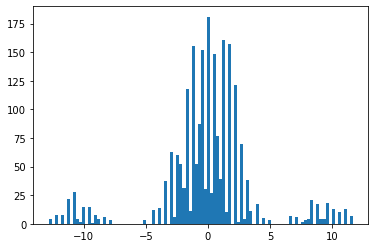

In [8]:
plt.hist(XYdf['score'],bins=100)
plt.show()

In [9]:
loc2seq = dict([(x,z) for (x,z) in XYdf[['locus_tag','seq6']].values])

print(locus2info['EQU24_RS19315'])
print(loc2seq['EQU24_RS19315'])


{'gene': 'pmoC', 'product': 'methane monooxygenase/ammonia monooxygenase subunit C', 'type': 'CDS'}
ATCAGG


### Train/test splitting
Use StratifiedShuffleSplit to make sure the percent of clases is preserved between train/test splits

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit 

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

Train counts:
1    1563
2     103
0     102
Name: task1_class, dtype: int64
Test counts:
1    391
0     26
2     26
Name: task1_class, dtype: int64


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


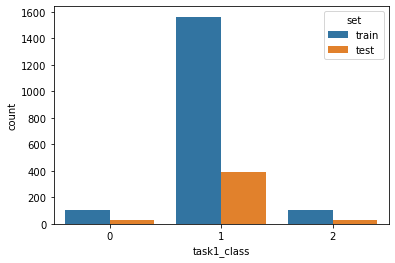

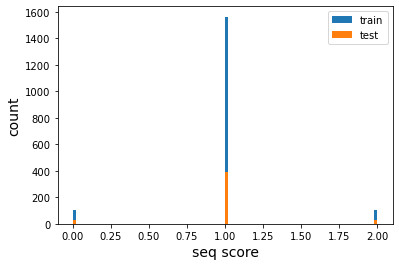

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


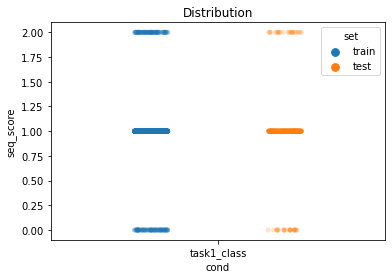

In [11]:
target_col = 'task1_class'
for i, (train_idxs, test_idxs) in enumerate(sss.split(XYdf, XYdf[target_col])):
    train_df = XYdf.iloc[train_idxs]
    test_df = XYdf.iloc[test_idxs]
    
    print(f"Train counts:\n{train_df[target_col].value_counts()}")
    print(f"Test counts:\n{test_df[target_col].value_counts()}")
    
    v.plot_train_test_stacks(train_df, test_df, score_col=target_col)
    v.plot_train_test_hist(train_df, test_df,score_col=target_col,bins=100)
    v.view_train_test_dist(train_df, test_df,[target_col],id_col='locus_tag')


## Load seqs into data loaders

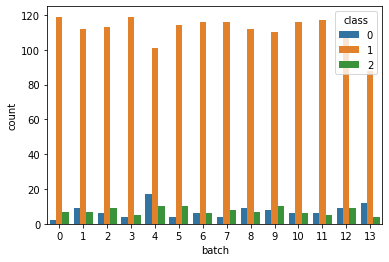

In [12]:
seq_col = 'seq6'
target_col = 'task1_class'

dataset_types = [
    DatasetSpec('ohe'),
]

dls = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)


ohe_train_dl,ohe_val_dl = dls['ohe']

v.see_batch_class_dist(ohe_train_dl)

## Run models and collect stats

In [13]:
class DNA_CNN_simple(nn.Module):
    def __init__(self,
                 seq_len,
                 num_tasks,
                 num_filters=31,
                 kernel_size=3
                ):
        super().__init__()
        self.seq_len = seq_len
        self.num_tasks = num_tasks
        self.lin_nodes = num_filters*(seq_len-kernel_size+1)
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            # ^^ changed from 4 to 1 channel??
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.lin_nodes, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.Linear(10,self.num_tasks),            
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix??
        out = self.conv_net(xb)
        return out


In [14]:
model_res = {}
pred_dfs = {}
seq_len = len(train_df[seq_col].values[0])

E:2321 | train loss:0.000 | val loss: 0.000:  77%|███████▋  | 2320/3000 [01:38<00:28, 24.01it/s]

EarlyStopping counter: 50 out of 200


E:2371 | train loss:0.000 | val loss: 0.000:  79%|███████▉  | 2371/3000 [01:40<00:26, 23.91it/s]

EarlyStopping counter: 100 out of 200


E:2421 | train loss:0.000 | val loss: 0.001:  81%|████████  | 2422/3000 [01:42<00:24, 24.06it/s]

EarlyStopping counter: 150 out of 200


E:2467 | train loss:0.000 | val loss: 0.001:  82%|████████▏ | 2467/3000 [01:44<00:22, 23.68it/s]


EarlyStopping counter: 200 out of 200
Early stopping


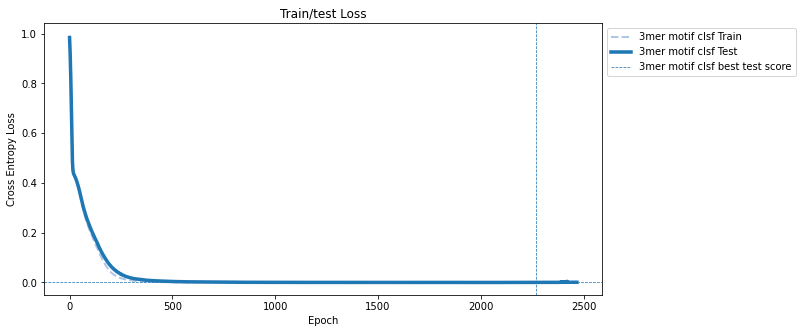

In [15]:
cnn1_name = "3mer motif clsf"
model = DNA_CNN_simple(
            seq_len,
            3, # num tasks
        )

model_res[cnn1_name] = tu.collect_model_stats(
    cnn1_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model,
    loss_type='classification'
)

Running predictions for 3mer motif clsf


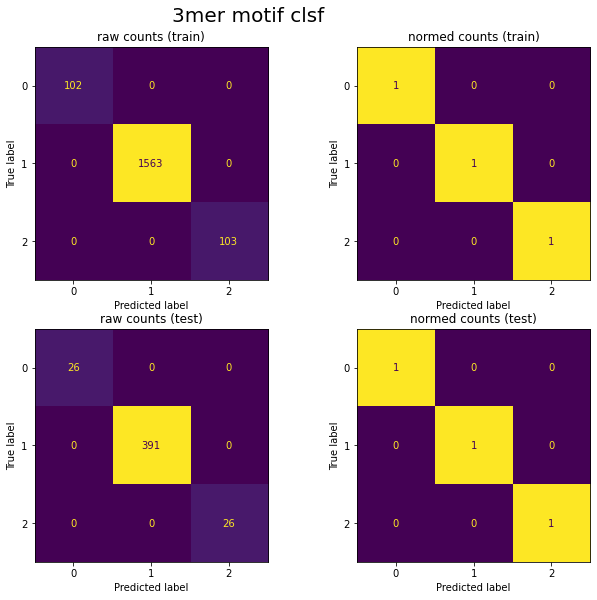

In [16]:
seq_list = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn1_name] = tu.get_confusion_stats(
    model_res[cnn1_name]['model'],
    model_res[cnn1_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn1_name]['model_name']}"
)

Even with no data augmentation/sample balancing, scoring based on two 3-mers in a sequence length of 6 is fairly easy to do for this simple CNN

# visualize the filters learned by the model

Total convolutional layers: 1
Num filters 31
filt_width 3
Seq 0 of 1768
Seq 100 of 1768
Seq 200 of 1768
Seq 300 of 1768
Seq 400 of 1768
Seq 500 of 1768
Seq 600 of 1768
Seq 700 of 1768
Seq 800 of 1768
Seq 900 of 1768
Seq 1000 of 1768
Seq 1100 of 1768
Seq 1200 of 1768
Seq 1300 of 1768
Seq 1400 of 1768
Seq 1500 of 1768
Seq 1600 of 1768
Seq 1700 of 1768
torch.Size([31, 4, 3])


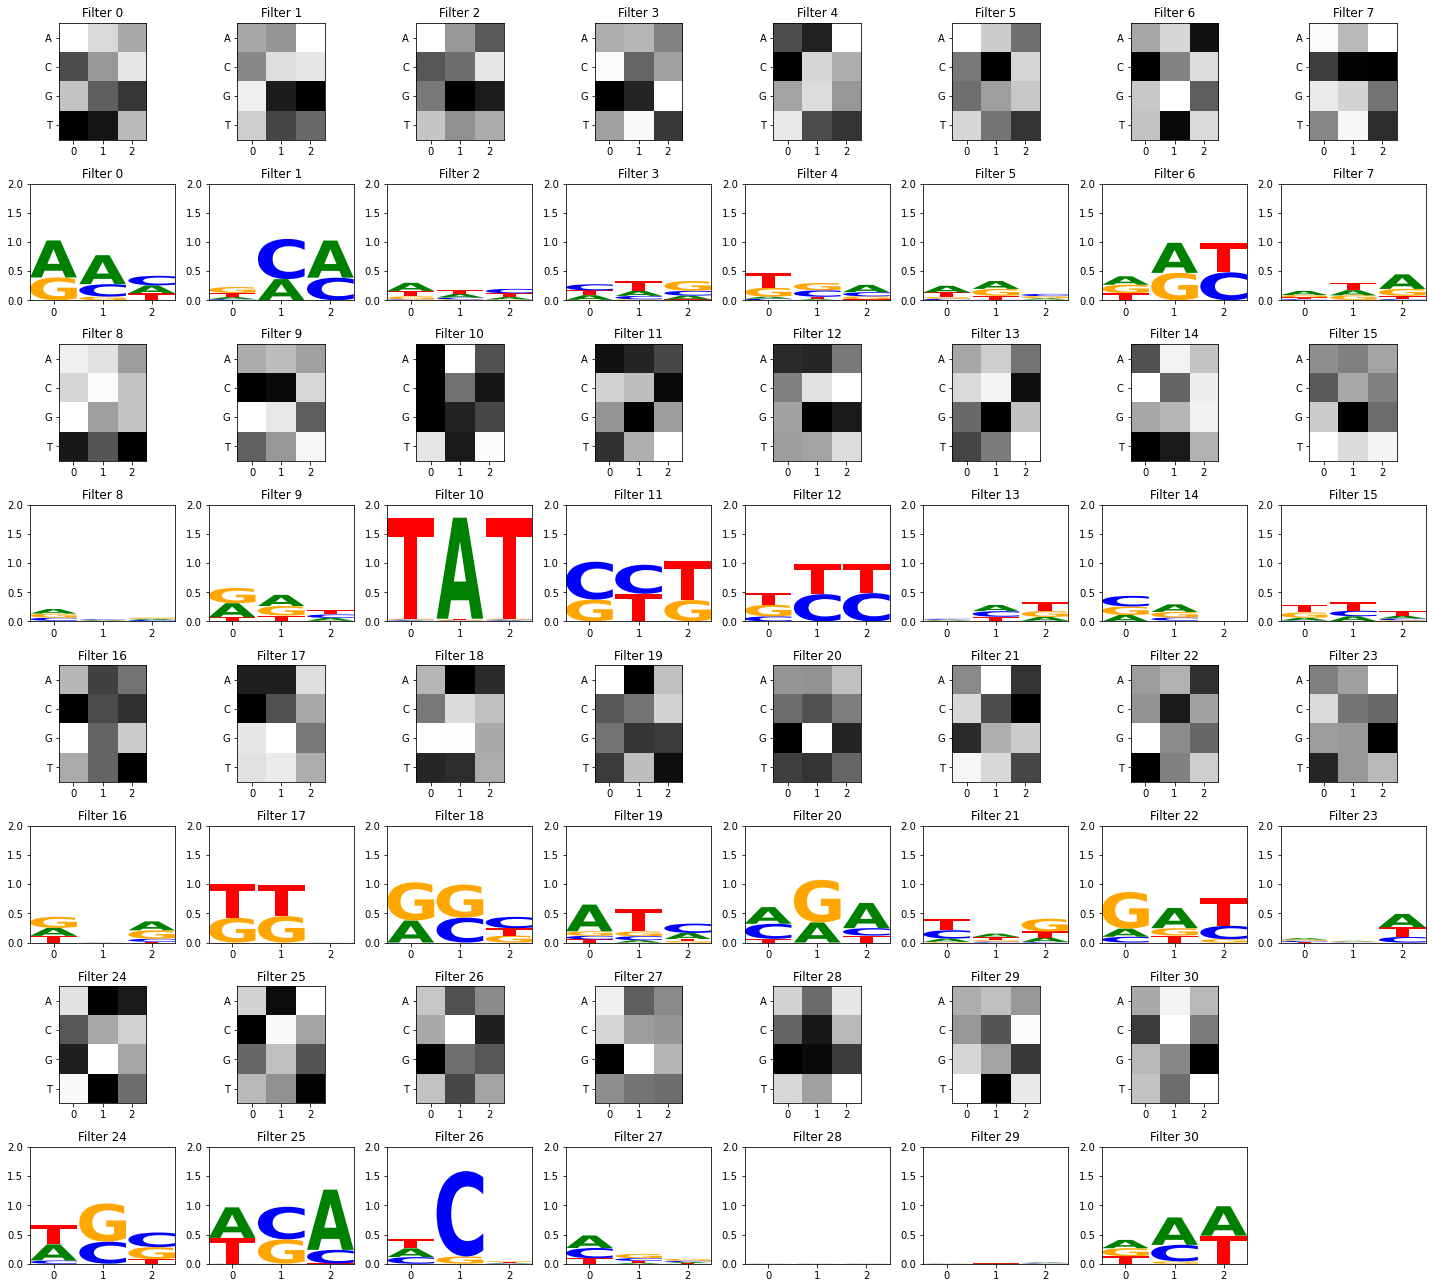

In [17]:
seqs = train_df[seq_col].values
v.view_conv2D_wrapper(model,seqs,DEVICE,act_thresh=0.5)

# Compare these results to shuffling the inputs sequences
Use the same class assignments for `posc` but shuffle the sequence so that the motif is usually lost

/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


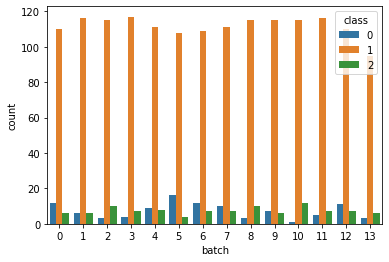

In [19]:
seq_col = 'seq6_shuff'
target_col = 'task1_class'

def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

train_df[seq_col] = train_df['seq6'].apply(lambda x: shuffle_seq(x))
test_df[seq_col] = test_df['seq6'].apply(lambda x: shuffle_seq(x))

dls_shuff = tu.build_dataloaders(
    train_df, 
    test_df, 
    dataset_types,
    seq_col=seq_col,
    target_col=target_col,
    sampler=None
)


ohe_train_dl_shuff,ohe_val_dl_shuff = dls_shuff['ohe']

v.see_batch_class_dist(ohe_train_dl_shuff)

E:265 | train loss:0.284 | val loss: 0.346:   9%|▉         | 264/3000 [00:11<02:02, 22.38it/s]

EarlyStopping counter: 50 out of 200


E:315 | train loss:0.271 | val loss: 0.349:  10%|█         | 315/3000 [00:13<01:54, 23.54it/s]

EarlyStopping counter: 100 out of 200


E:365 | train loss:0.260 | val loss: 0.353:  12%|█▏        | 366/3000 [00:16<01:59, 22.01it/s]

EarlyStopping counter: 150 out of 200


E:411 | train loss:0.251 | val loss: 0.359:  14%|█▎        | 411/3000 [00:18<01:54, 22.59it/s]


EarlyStopping counter: 200 out of 200
Early stopping


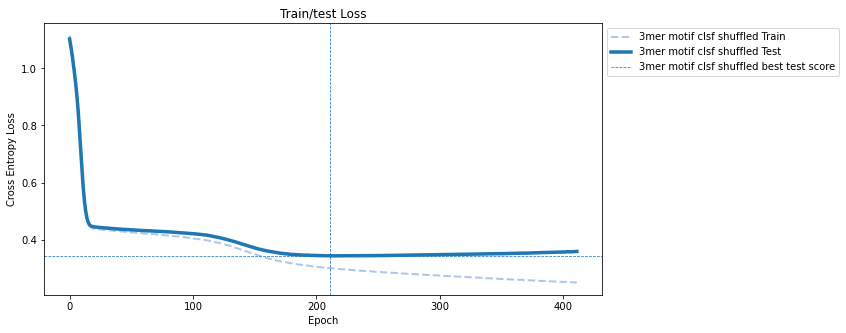

In [20]:
cnn2_name = "3mer motif clsf shuffled"
model2 = DNA_CNN_simple(
            seq_len,
            3, # num tasks
        )

model_res[cnn2_name] = tu.collect_model_stats(
    cnn2_name,
    seq_len,
    ohe_train_dl_shuff,
    ohe_val_dl_shuff,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model2,
    loss_type='classification'
)

Running predictions for 3mer motif clsf shuffled


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


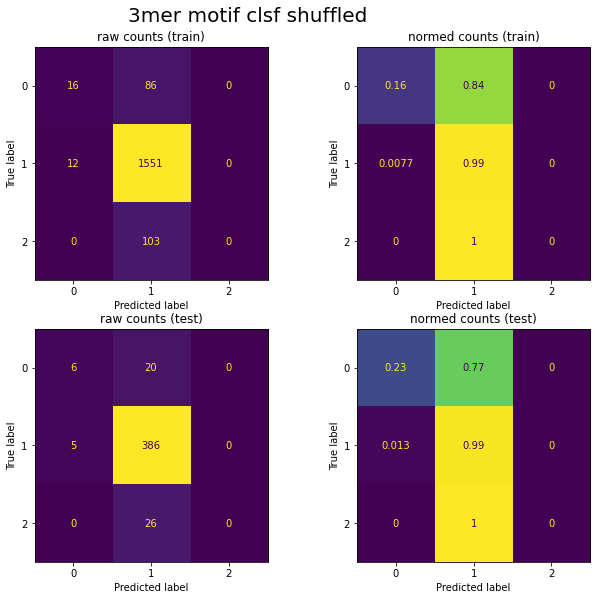

In [21]:
seq_list_shuff = [
    (train_df[seq_col].values,train_df[target_col],"train"),
    (test_df[seq_col].values,test_df[target_col],"test")
]

pred_dfs[cnn2_name] = tu.get_confusion_stats(
    model_res[cnn2_name]['model'],
    model_res[cnn2_name]['model_name'],
    seq_list_shuff,
    DEVICE,
    title=f"{model_res[cnn2_name]['model_name']}"
)

E:283 | train loss:0.226 | val loss: 0.379:   6%|▌         | 282/5000 [00:12<03:18, 23.77it/s]

EarlyStopping counter: 125 out of 500


E:408 | train loss:0.186 | val loss: 0.441:   8%|▊         | 408/5000 [00:17<03:15, 23.45it/s]

EarlyStopping counter: 250 out of 500


E:533 | train loss:0.151 | val loss: 0.516:  11%|█         | 534/5000 [00:22<03:10, 23.49it/s]

EarlyStopping counter: 375 out of 500


E:654 | train loss:0.122 | val loss: 0.605:  13%|█▎        | 654/5000 [00:28<03:07, 23.20it/s]


EarlyStopping counter: 500 out of 500
Early stopping


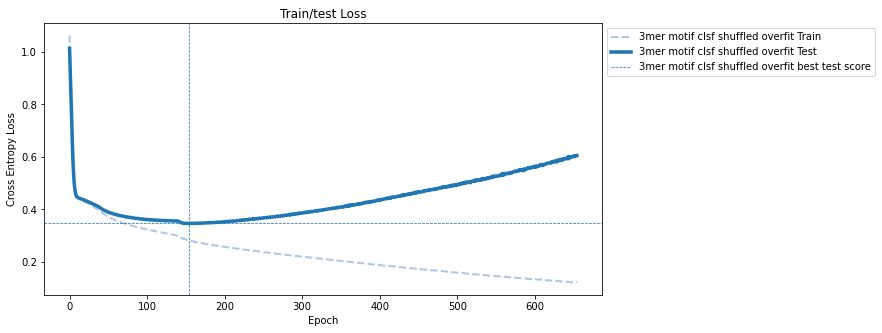

Running predictions for 3mer motif clsf shuffled overfit


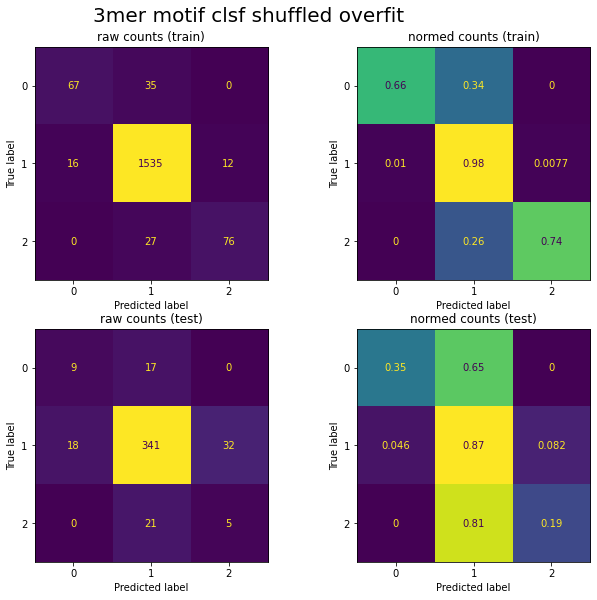

In [22]:
cnn3_name = "3mer motif clsf shuffled overfit"
model3 = DNA_CNN_simple(
            seq_len,
            3, # num tasks
            num_filters=200
        )

model_res[cnn3_name] = tu.collect_model_stats(
    cnn3_name,
    seq_len,
    ohe_train_dl_shuff,
    ohe_val_dl_shuff,
    DEVICE,
    lr=0.0001,
    ep=5000,
    pat=500,
    opt=torch.optim.Adam,
    model=model3,
    loss_type='classification',
    load_best=False
)

pred_dfs[cnn3_name] = tu.get_confusion_stats(
    model_res[cnn3_name]['model'],
    model_res[cnn3_name]['model_name'],
    seq_list_shuff,
    DEVICE,
    title=f"{model_res[cnn3_name]['model_name']}"
)

### Try one more really small model

E:1944 | train loss:0.005 | val loss: 0.039:  65%|██████▍   | 1944/3000 [01:22<00:43, 24.05it/s]

EarlyStopping counter: 50 out of 200


E:2006 | train loss:0.004 | val loss: 0.039:  67%|██████▋   | 2007/3000 [01:24<00:41, 24.09it/s]

EarlyStopping counter: 50 out of 200


E:2056 | train loss:0.003 | val loss: 0.040:  68%|██████▊   | 2055/3000 [01:27<00:40, 23.59it/s]

EarlyStopping counter: 100 out of 200


E:2106 | train loss:0.003 | val loss: 0.041:  70%|███████   | 2106/3000 [01:29<00:37, 23.88it/s]

EarlyStopping counter: 150 out of 200


E:2152 | train loss:0.002 | val loss: 0.042:  72%|███████▏  | 2152/3000 [01:31<00:35, 23.63it/s]


EarlyStopping counter: 200 out of 200
Early stopping


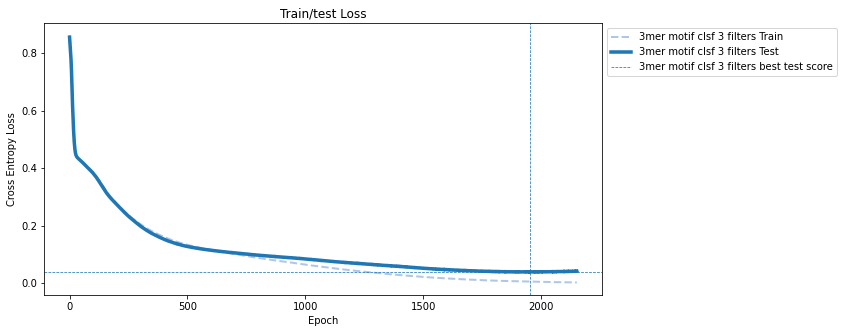

Running predictions for 3mer motif clsf 3 filters


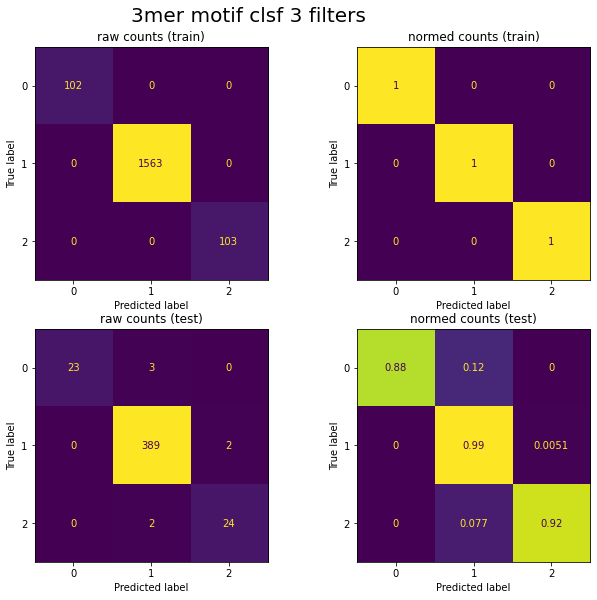

In [23]:
cnn4_name = "3mer motif clsf 3 filters"
model4 = DNA_CNN_simple(
            seq_len,
            3, # num tasks
            num_filters=3,
        )

model_res[cnn4_name] = tu.collect_model_stats(
    cnn4_name,
    seq_len,
    ohe_train_dl,
    ohe_val_dl,
    DEVICE,
    lr=0.0001,
    ep=3000,
    pat=200,
    opt=torch.optim.Adam,
    model=model4,
    loss_type='classification'
)

pred_dfs[cnn4_name] = tu.get_confusion_stats(
    model_res[cnn4_name]['model'],
    model_res[cnn4_name]['model_name'],
    seq_list,
    DEVICE,
    title=f"{model_res[cnn4_name]['model_name']}"
)

Total convolutional layers: 1
Num filters 3
filt_width 3
Seq 0 of 1768
Seq 100 of 1768
Seq 200 of 1768
Seq 300 of 1768
Seq 400 of 1768
Seq 500 of 1768
Seq 600 of 1768
Seq 700 of 1768
Seq 800 of 1768
Seq 900 of 1768
Seq 1000 of 1768
Seq 1100 of 1768
Seq 1200 of 1768
Seq 1300 of 1768
Seq 1400 of 1768
Seq 1500 of 1768
Seq 1600 of 1768
Seq 1700 of 1768
torch.Size([3, 4, 3])


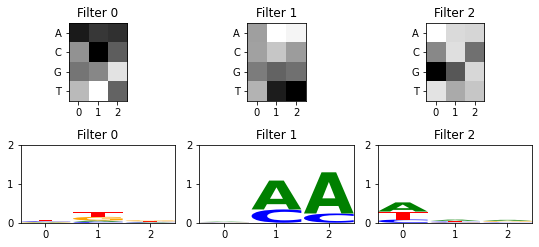

In [24]:
seqs = train_df['seq6'].values
v.view_conv2D_wrapper(model4,seqs,DEVICE,act_thresh=0.5,ysc=0.25)

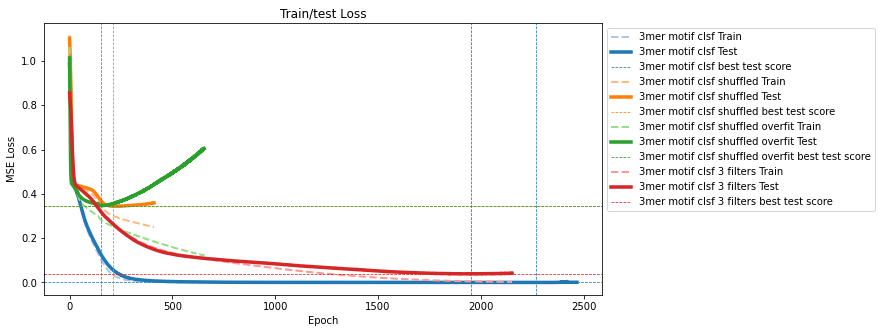

In [25]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [26]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support
0,3mer motif clsf,train,1.000000,1.000000,1.000000,1768
1,3mer motif clsf,test,1.000000,1.000000,1.000000,443
0,3mer motif clsf shuffled,train,0.487603,0.383062,0.395100,1768
1,3mer motif clsf shuffled,test,0.479658,0.405994,0.420785,443
0,3mer motif clsf shuffled overfit,train,0.877347,0.792271,0.830552,1768
1,3mer motif clsf shuffled overfit,test,0.456068,0.470195,0.461356,443
0,3mer motif clsf 3 filters,train,1.000000,1.000000,1.000000,1768
1,3mer motif clsf 3 filters,test,0.970129,0.934192,0.950978,443


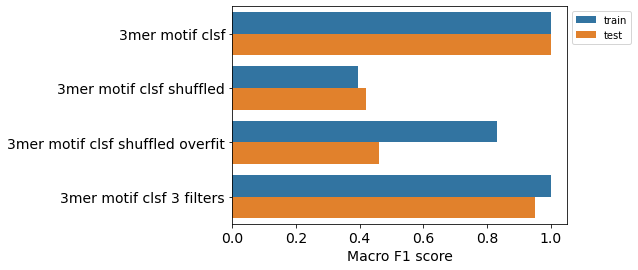

In [27]:
sns.barplot(data=all_preds,y='model_name',x='mac_f1',hue='split',dodge=True)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.xlabel("Macro F1 score",fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
plt.show()

With a little tinkering this example demonstrates an easy learning example: predict sequence class based on the presence or absence of a 3-mer motif within a 6bp sequence. Even a really small model with only 3 filters was able to learn this perfectly (though more slowly). When the sequences are shuffled (thereby dispersing the original signal by which the sequences were assigned classes), the models are no longer after to learn to classify them. 

Now let's increase the difficulty of the synthetic task.

For this second round, let's keep the sequences at 300bp long (instead of reducing to 6bp) and see if we can learn to classify based on a pair of 6-mers